In [1]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tensorflow.keras.applications.resnet50 import ResNet50 

## <font color='red'> Training Set </font>

In [2]:
train_label_0 = glob.glob('datasets/RSNA-Pneumonia-Detection-Challenge/stage_2_train_images_Processed/train/0/*.png')
train_label_1 = glob.glob('datasets/RSNA-Pneumonia-Detection-Challenge/stage_2_train_images_Processed/train/1/*.png')
len(train_label_0),len(train_label_1)

(18593, 17407)

In [3]:
train_image_paths = train_label_0 + train_label_1

In [4]:
train_labels = [0] * len(train_label_0) +  [1]* len(train_label_1)
train_labels[:5],train_labels[-5:]

([0, 0, 0, 0, 0], [1, 1, 1, 1, 1])

In [5]:
training_df = pd.DataFrame({'image_path':train_image_paths,
                           'labels':train_labels})
training_df.to_csv('pneumonia-training-set.csv')
training_df.head()

,image_path,labels
0,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
1,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
2,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
3,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
4,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0


# <font color='blue'> Validation set<font> 

In [6]:
val_label_0 = glob.glob('datasets/RSNA-Pneumonia-Detection-Challenge/stage_2_train_images_Processed/val/0/*')
val_label_1 = glob.glob('datasets/RSNA-Pneumonia-Detection-Challenge/stage_2_train_images_Processed/val/1/*')
len(val_label_0),len(val_label_1)

(2079, 605)

In [7]:
val_image_paths = val_label_0 + val_label_1

In [8]:
val_labels = [0] * len(val_label_0) +  [1] * len(val_label_1)
val_labels[:5],val_labels[-5:]

([0, 0, 0, 0, 0], [1, 1, 1, 1, 1])

In [9]:
validation_df = pd.DataFrame({'image_path':val_image_paths,
                           'labels':val_labels})
validation_df.to_csv('pneumonia-validation-set.csv')
validation_df.head()

,image_path,labels
0,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
1,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
2,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
3,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0
4,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0


### <font color='purple'>Create TF Dataset for training</font>

In [10]:
BATCH_SIZE = 32

In [11]:
@tf.function
def load_image(image_path,label):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image,dtype=tf.float32)
    image = image / 255.0
    
    # Onehot-Encoding
    label = tf.one_hot(label, 2)

    return (image, label)

# Data Augmentation
# This decorator tells TensorFlow to take our Python function and convert it into a TensorFlow-callable graph. 
@tf.function
def augmentation(image, label):
    # perform random horizontal and vertical flips
    image = tf.image.central_crop(image,central_fraction=0.85)
    image = tf.image.resize(image,size=(224,224))
    
    # return the image and the label
    return (image, label)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((training_df['image_path'],training_df['labels']))
dataset = (dataset.shuffle(len(training_df))
                  .map(load_image).map(augmentation)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE)
          )

### <font color='purple'>Create TF Dataset for Validation</font>

In [13]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths,val_labels))
valid_dataset = (valid_dataset.map(load_image).map(augmentation)
                              .batch(BATCH_SIZE)
          )

###### <font color='purple'>Create TF Dataset for GradCAM</font>


In [14]:
grad_cam_df = validation_df[-10:]
grad_cam_df.head()

,image_path,labels
2674,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1
2675,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1
2676,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1
2677,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1
2678,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1


In [15]:
grad_image_paths = grad_cam_df['image_path'].to_list()
grad_label_1     = grad_cam_df['labels'].to_list()

In [16]:
grad_imgs = []
for img_path in grad_image_paths:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image,dtype=tf.float32)
    image = image / 255.0
    grad_imgs.append(image.numpy())
grad_imgs = np.array(grad_imgs)
grad_label_1 = tf.one_hot(np.array(grad_label_1),2)

In [17]:
len(grad_imgs)

10

In [18]:
grad_label_1

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

### <font color='green'>Calculate class weights</font>

In [19]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(train_label_0)) * ((len(train_label_0)+len(train_label_1)) / 2.0)
weight_for_1 = (1 / len(train_label_1)) * ((len(train_label_0)+len(train_label_1)) / 2.0) + 0.05

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.97
Weight for class 1: 1.08


In [20]:
for x, y in dataset.take(1):
    print(x.shape)

(32, 224, 224, 1)


## Building Model using Transfer Learning

In [21]:
base_model = ResNet50(input_shape=(224,224,1),
                         include_top=False,weights=None,pooling='avg')

In [22]:
# Customize the output layers
flatten_all = tf.keras.layers.Flatten()(base_model.output)
Dense_1 = tf.keras.layers.Dense(units=512,activation='relu')(flatten_all)
prediction_layer = tf.keras.layers.Dense(units=2, activation='softmax')(Dense_1)

# Concatenate the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics='accuracy')

In [23]:
# model.summary()

In [24]:
# tf.keras.utils.plot_model(model,to_file='mobilenetV2-Pneumonia.png',show_shapes=True)

#### <font color='red'> Callbacks <font>

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
es = EarlyStopping(patience=5,restore_best_weights=True)

In [28]:
callbacks = [
    GradCAMCallback(
        validation_data=(grad_imgs, grad_label_1),
        layer_name="conv5_block3_3_conv",
        class_index=1,
    ),
#         SmoothGradCallback(
#             validation_data=(grad_imgs, grad_label_1),
#             class_index=0,
#             num_samples=5,
#             noise=1.0,
#     ),
#      OcclusionSensitivityCallback(
#         validation_data=(grad_imgs, grad_label_1),
#         class_index=0,
#         patch_size=4,
#     ),
    es,
]

In [29]:
history = model.fit(dataset,
                    epochs=30,
                    validation_data=valid_dataset,
                    class_weight=class_weight,callbacks=[callbacks])

Epoch 1/30
1125/1125 [==============================] - 252s 218ms/step - loss: 0.5690 - accuracy: 0.7565 - val_loss: 3.2242 - val_accuracy: 0.2291
Epoch 2/30
1125/1125 [==============================] - 247s 220ms/step - loss: 0.4477 - accuracy: 0.8012 - val_loss: 0.9875 - val_accuracy: 0.3923
Epoch 3/30
1125/1125 [==============================] - 245s 218ms/step - loss: 0.4247 - accuracy: 0.8112 - val_loss: 0.4704 - val_accuracy: 0.7798
Epoch 4/30
1125/1125 [==============================] - 248s 221ms/step - loss: 0.4113 - accuracy: 0.8174 - val_loss: 0.5459 - val_accuracy: 0.7444
Epoch 5/30
1125/1125 [==============================] - 245s 218ms/step - loss: 0.4003 - accuracy: 0.8208 - val_loss: 0.6959 - val_accuracy: 0.5760
Epoch 6/30
1125/1125 [==============================] - 245s 218ms/step - loss: 0.3875 - accuracy: 0.8285 - val_loss: 0.5949 - val_accuracy: 0.6710
Epoch 7/30
1125/1125 [==============================] - 246s 219ms/step - loss: 0.3770 - accuracy: 0.8340 - val_

### Evaluation

<AxesSubplot:>

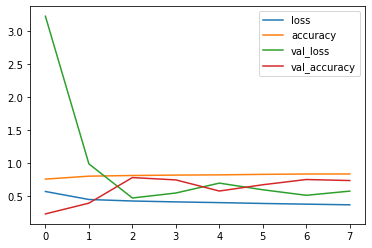

In [30]:
loss = pd.DataFrame(history.history)
loss.plot()

<AxesSubplot:>

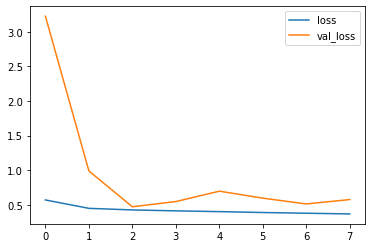

In [31]:
loss[['loss','val_loss']].plot()

<AxesSubplot:>

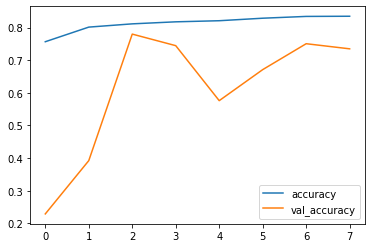

In [33]:
loss[['accuracy','val_accuracy']].plot()

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [42]:
predictions = model.predict(valid_dataset)


array([0.01186976, 0.0134279 , 0.01396635, ..., 0.9860336 , 0.98657215,
       0.9881302 ], dtype=float32)

In [47]:
predictions = np.argmax(predictions,axis=1)

In [48]:
predictions

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [49]:
y_true = validation_df['labels']

In [50]:
cm = confusion_matrix(y_true,predictions)
cm

array([[1764,  315],
       [ 276,  329]], dtype=int64)

In [51]:
print(classification_report(y_true,predictions))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2079
           1       0.51      0.54      0.53       605

    accuracy                           0.78      2684
   macro avg       0.69      0.70      0.69      2684
weighted avg       0.78      0.78      0.78      2684



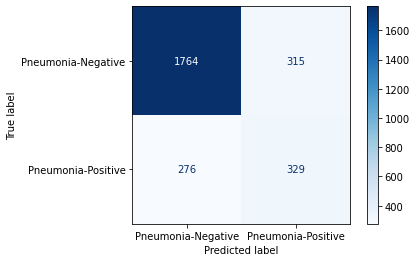

In [52]:
disp = ConfusionMatrixDisplay(cm,display_labels=['Pneumonia-Negative','Pneumonia-Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Exporting Miclassified images

In [53]:
miss_classified = []
for idx,labels in enumerate(zip(y_true,predictions)):
#     print(idx,labels)
    if labels[0] != labels[1]:
        miss_classified.append(idx)
len(miss_classified)

591

In [54]:
miss_classified[:5]

[0, 5, 20, 56, 61]

In [55]:
missed_df = validation_df.iloc[miss_classified]

In [56]:
missed_df['pre_labels'] = missed_df['labels'].map({0:1,
                                                   1:0})

C:\Users\user\AppData\Local\Temp/ipykernel_1188/1742523887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed_df['pre_labels'] = missed_df['labels'].map({0:1,


In [57]:
missed_df

,image_path,labels,pre_labels
0,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0,1
5,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0,1
20,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0,1
56,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0,1
61,datasets/RSNA-Pneumonia-Detection-Challenge/st...,0,1
...,...,...,...
2663,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1,0
2668,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1,0
2673,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1,0
2675,datasets/RSNA-Pneumonia-Detection-Challenge/st...,1,0


In [58]:
missed_df.to_csv('MisClassified_Results.csv',index_label=0)

#### Exporting Model

In [59]:
tf.keras.models.save_model(model,filepath='./pneu-model')

INFO:tensorflow:Assets written to: ./pneu-model\assets


C:\Users\user\anaconda3\envs\tensorflow2\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\user\anaconda3\envs\tensorflow2\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
